# Análisis de datos y modelado

## 0. Configurando entorno

In [6]:
import os

JAVA_8_PATH = "/usr/lib/jvm/temurin-8-jdk-amd64" 

os.environ["JAVA_HOME"] = JAVA_8_PATH
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

print(f"JAVA_HOME configurado a: {os.environ.get('JAVA_HOME')}")

JAVA_HOME configurado a: /usr/lib/jvm/temurin-8-jdk-amd64


## 1. Leyendo datos limpios desde hadoop

In [7]:
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder \
    .appName("ModeloFacebook") \
    .config("spark.network.timeout", "6000s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

25/11/22 11:13:03 WARN Utils: Your hostname, vbox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/11/22 11:13:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 11:13:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
spark

In [8]:
coments_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .csv("hdfs://localhost:9000/user/upao/processed/facebook/facebook_coments_clean.csv")

coments_df.printSchema()
print("Filas:", coments_df.count())
coments_df.show(5)

root
 |-- post_id: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- comment_date: timestamp (nullable = true)
 |-- reaction_count: integer (nullable = true)



Filas: 623179
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|e132943d-b740-48a...|88ef00aa-f56e-4b5...|Gracias por el da...|       Cristian Mayo|552d5bf8-c9e0-4a1...|2024-12-23 20:38:...|            50|
|e132943d-b740-48a...|68bfa1d8-274a-450...|Uff, yo también t...|   Roldán Arias Jove|8a01b3a1-4a62-4f5...|2025-01-23 00:09:...|             3|
|e132943d-b740-48a...|b0d5beb8-a735-45e...|Si vas a Machu Pi...|Bernardo de Rosselló|4370d5bf-39d6-4ad...|2025-05-23 05:43:...|            33|
|e132943d-b740-48a...|c1ee05b3-7024-407...|Crecí cerca de Ma...|  Áurea Elorza-Marin|0a122838-d6e1-4b6...|2025-10-26 00:55:...| 

In [5]:
posts_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("encoding", "UTF-8") \
    .option("delimiter", ",") \
    .csv("hdfs://localhost:9000/user/upao/processed/facebook/facebook_posts_clean.csv")

posts_df.printSchema()
print("Filas:", posts_df.count())
posts_df.show(5)

root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comment_count: integer (nullable = true)

Filas: 37997
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|           1036|           21|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|            927|           10|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2024-12-06 17:31:...|           1605|           12|
|00403888-5440-45e...|Luca

## 2. Extracción de features y creación del dataset para entrenamiento

### 2.1 Extraccion de destino turístico mediante diccionario de palabras claves 

In [5]:
destinos = [
    "Máncora", "Punta Sal", "Zorritos", "Acapulco", "Cancas",
    "Puerto Pizarro", "Bocapán", "Playa Hermosa", "Caleta Grau",
    "Los Órganos", "Vichayito", "Cabo Blanco", "Lobitos", "Colán",
    "El Ñuro", "Las Pocitas", "Negritos", "Paita", "Yacila",
    "Nonura", "Chulliyachi", "Matacaballo", "Constante", "Bayóvar",
    "Pimentel", "Puerto Eten", "San José", "Santa Rosa", "Laguna Azul",
    "Huanchaco", "Pacasmayo", "Puerto Chicama", "Las Delicias", "Salaverry",
    "Puerto Morín", "Chepén", "Cherrepe", "Guañape",
    "Casma", "Chimbote", "Tortugas", "Huarmey",
    "La Pocita", "Tamborero", "Antivito", "Samanco", "Besique",
    "Culebras", "Puerto Supe", "Végueta", "Barranca","Tumbes", "Zarumilla", "Aguas Verdes", "Corrales",
    "Piura", "Sullana", "Talara", "Paita", "Catacaos",
    "Chulucanas", "Sechura", "Morropón", "Huancabamba", "Ayabaca",
    "La Unión", "Canchaque", "Tambo Grande",
    "Chiclayo", "Lambayeque", "Ferreñafe", "Monsefú", "Olmos",
    "Motupe", "Jayanca", "Túcume", "Mórrope", "Zaña",
    "Trujillo", "Pacasmayo", "Chepén", "Ascope", "Otuzco",
    "Huamachuco", "Santiago de Chuco", "Virú", "Guadalupe",
    "San Pedro de Lloc", "Moche", "Chao",
    "Cajamarca", "Baños del Inca", "Celendín", "Chota", "Cutervo",
    "Jaén", "San Ignacio", "Bambamarca", "Contumazá", "Cajabamba",
    "Chachapoyas", "Bagua Grande", "Bagua", "Lamud", "Luya",
    "Rodríguez de Mendoza","Moyobamba", "Rioja", "Tarapoto", "Juanjuí","Chan Chan", "Huaca de la Luna", "Huaca del Sol", "Complejo El Brujo",
    "Huaca del Dragón", "Huaca Esmeralda", "Marcahuamachuco",
    "Wiracochapampa", "Galindo", "Farfán", "San José de Moro",
    "Museo Señor de Sipán", "Bosque de Pómac", "Complejo de Túcume",
    "Huaca Rajada", "Tumbas Reales de Sipán", "Chotuna Chornancap",
    "Ventarrón", "Collud-Zarpán", "Huaca Bandera", "Cinto",
    "Kuélap", "Sarcófagos de Karajía", "Revash", "Gran Vilaya",
    "Laguna de los Cóndores", "Yalape", "Macro", "Pueblo de los Muertos",
    "Ventanillas de Otuzco", "Cumbemayo", "Kuntur Wasi", "Pacopampa",
    "Ventanillas de Combayo", "Necrópolis de Combayo",
    "Templo de Chavín de Huántar", "Sechín", "Pañamarca", "Huaca de Punkurí",
    "Castillo de Huarmey", "Chankillo", "Pashash", "Paramonga",
    "Aypate", "Huaca Narihualá", "Chusis", "Cerro Vicús", "Cabeza de Vaca",
    "Ciudad Sagrada de Caral", "Áspero", "Vichama", "Bandurria", "Complejo Paraíso","Chan Chan", "Huaca de la Luna", "Huaca del Sol", "Complejo El Brujo",
    "Huaca del Dragón", "Huaca Esmeralda", "Marcahuamachuco",
    "Wiracochapampa", "Galindo", "Farfán", "San José de Moro",
    "Museo Señor de Sipán", "Bosque de Pómac", "Complejo de Túcume",
    "Huaca Rajada", "Tumbas Reales de Sipán", "Chotuna Chornancap",
    "Ventarrón", "Collud-Zarpán", "Huaca Bandera", "Cinto",
    "Kuélap", "Sarcófagos de Karajía", "Revash", "Gran Vilaya",
    "Laguna de los Cóndores", "Yalape", "Macro", "Pueblo de los Muertos",
    "Ventanillas de Otuzco", "Cumbemayo", "Kuntur Wasi", "Pacopampa",
    "Ventanillas de Combayo", "Necrópolis de Combayo",
    "Templo de Chavín de Huántar", "Sechín", "Pañamarca", "Huaca de Punkurí",
    "Castillo de Huarmey", "Chankillo", "Pashash", "Paramonga",
    "Aypate", "Huaca Narihualá", "Chusis", "Cerro Vicús", "Cabeza de Vaca",
    "Ciudad Sagrada de Caral", "Áspero", "Vichama", "Bandurria", "Complejo Paraíso","Cusco", "Arequipa", "Puno", "Huaraz", "Cajamarca",
    "Ayacucho", "Huancayo", "Huánuco", "Cerro de Pasco", "Abancay",
    "Huancavelica", "Chachapoyas", "Moquegua", "Ollantaytambo", "Pisac",
    "Urubamba", "Calca", "Chivay", "Yanque", "Jauja",
    "Tarma", "La Oroya", "Baños del Inca", "Celendín", "Chota",
    "Cutervo", "Bambamarca", "Cajabamba", "Contumazá",
    "Huamachuco", "Santiago de Chuco", "Otuzco", "Caraz", "Yungay",
    "Chacas", "Huari", "Pomabamba", "Recuay", "Andahuaylas",
    "Juliaca", "Lampa", "Ayaviri", "Desaguadero", "Yunguyo",
    "Concepción", "Chupaca", "Sicaya", "Carhuamayo", "Lamud", "Luya","Pachacámac", "Huaca Pucllana", "Huaca Huallamarca", "Complejo Mateo Salado",
    "Puruchuco", "Sacsayhuamán", "Ollantaytambo", "Pisac", "Moray",
    "Tipón", "Piquillacta", "Choquequirao", "Sillustani", "Cutimbo",
    "Pukara", "Complejo Arqueológico Wari", "Intihuatana de Vilcashuamán",
    "Gran Pajatén", "Kotosh", "Tunanmarca", "Arwaturo", "Tambo Colorado",
    "Petroglifos de Toro Muerto", "Willkawaín", "Honcopampa", "Tambo de Mora",
    "Incahuasi de Cañete", "Huaytará", "Ushnu de Huanacopampa", "Pikimachay",
    "Qenqo", "Tambomachay", "Puca Pucara", "Huchuy Qosqo", "Chinchero",
    "Vitcos", "Espíritu Pampa", "Runkurakay", "Sayacmarca", "Phuyupatamarca",
    "Wiñay Wayna", "Petroglifos de Checta", "Fortaleza de Collique",
    "Cantamarca", "Rúpac", "Chiprac", "Fortaleza de Acaray", "Las Shicras",
    "Pampa de las Llamas-Moxeke", "Cerro Sechín", "Garagay", "Cardal",
    "Cahuachi", "Estaquería", "Paredones", "Petroglifos de Miculla", "Cerro Baúl",
    "Reserva Nacional Pacaya Samiria", "Río Amazonas", "Reserva Nacional Tambopata",
    "Parque Nacional del Manu", "Lago Sandoval", "Collpa de Guacamayos Chuncho",
    "Laguna Yarinacocha", "Cueva de las Lechuzas", "Parque Nacional Tingo María",
    "Cataratas de Ahuashiyacu", "Laguna de Sauce", "Castillo de Lamas",
    "Petroglifos de Polish", "Comunidad Nativa Boras", "Comunidad Nativa Yaguas",
    "Isla de los Monos", "Malecón de Iquitos", "Barrio de Belén",
    "Mercado de Belén", "Complejo Turístico Quistococha", "Mariposario Pilpintuwasi",
    "Cocha Otorongo", "Cocha Salvador", "Parque Nacional Yanachaga-Chemillén",
    "Catarata Velo de la Novia", "Boquerón del Padre Abad", "Catarata de Yulitunqui",
    "Aguas Sulfurosas de Jacintillo", "La Bella Durmiente",
    "Baños Termales Paucaryacu", "Reserva Comunal Yanesha",
    "Jardín Botánico de Pucallpa", "Plaza de Armas de Iquitos", "Casa de Fierro",
    "Lago Tres Chimbadas", "Reserva Nacional Allpahuayo-Mishana",
    "Cataratas de Tsyapo", "Río Tambopata", "Río Madre de Dios",
    "Collpa de Loros El Infierno", "Valle de Chanchamayo", "Catarata de Bayoz",
    "Catarata de Tinamuz", "Reserva Indígena Amarakaeri", "Río Ene",
    "Río Apurímac", "Pongo de Manseriche", "Santuario Nacional Pampa Hermosa",
    "Comunidad Nativa Asháninka", "Catarata El Encanto de la Sirena",
    "Catarata de Regalía", "Jardín Botánico de Iquitos",
    "Comunidad Nativa Shipibo-Conibo", "Río Huallaga", "Río Ucayali",
    "Río Marañón","Iquitos", "Puerto Maldonado", "Pucallpa", "Tingo María", "Oxapampa",
    "Pozuzo", "Villa Rica", "La Merced", "San Ramón", "Pichanaki",
    "Nauta", "Lamas", "Sauce", "Aguaytía", "Quillabamba",
    "Atalaya", "Satipo", "Mazamari", "Requena", "Contamana",
    "Iberia", "Iñapari", "Santa María de Nieva", "Bellavista", "Saposoa",
    "Tocache", "Pilcopata", "Puerto Inca", "Ciudad Constitución", "Yurimaguas",
    "Caballococha", "Tamshiyacu", "Indiana", "Mazán", "San Lorenzo",
    "Santa Rosa de Yavarí", "Jepelacio", "Nueva Cajamarca", "Soritor",
    "Pacayzapa", "Pebas", "Pucacaca", "San Hilarión", "Shapaja",
    "Chazuta", "Tabalosos", "San José de Sisa", "Sarayacu", "Orellana",
    "Jenaro Herrera", "Bretaña", "Lagunas", "Balsapuerto", "Huicungo",
    "Pachiza","Petroglifos de Cunchipata",
    "Petroglifos de Shampuyacu",
    "Petroglifos de Balsapuerto",
    "Petroglifos de Quiaca",
    "Petroglifos de Pongo de Mainique",
    "Ruinas de Tantamayo",
    "Complejo Arqueologico de Uchkupishqo",
    "Ruinas de Chipuric",
    "Petroglifos de Faical",
    "Petroglifos de Samanga",
    "Petroglifos de Manga",
    "Petroglifos de Queros",
    "Sitio Arqueologico de Timbara",
    "Petroglifos de Catarata",
    "Petroglifos de Panguana",
    "Petroglifos de Pusac",
    "Petroglifos de San Antonio",
    "Petroglifos de Chazuta",
    "Tumbas Colgantes de la Jalca",
    "Mausoleos de Oton",
    "Mausoleos de Diablo Wasi",
    "Templo de Llama-G",
    "Fortaleza de Huaylillas",
    "Ruinas de Pirca Pirca",
    "Ruinas de Purunllacta",
    "Tumbas de Leca",
    "Tumbas de La Petaca",
    "Tumbas de Chipurik",
    "Sitio Arqueologico de Llactapata",
    "Petroglifos de Che-Che",
    "Petroglifos de Pitumarka",
    "Petroglifos de Santa Rosa",
    "Petroglifos de Chivay",
    "Petroglifos de Santa Cruz",
    "Petroglifos de Yamon",
    "Petroglifos de Utco",
    "Petroglifos de Limones",
    "Petroglifos de San Martin",
    "Petroglifos de Cacatachi",
    "Petroglifos de Shilcayo",
    "Petroglifos de Pumahuasi",
    "Petroglifos de Tunshuhuaico",
    "Petroglifos de Juanjui",
    "Petroglifos de Bellavista",
    "Petroglifos de Picota",
    "Templo de las Manos Cruzadas de Tingo Maria",
    "Ruinas de Saposoa",
    "Ruinas de Shunte",
    "Ruinas de Condormarca",
    "Complejo Arqueologico El Sapo",
    "Ruinas de la Conga"
]

#### A) Tabla Posts

In [13]:
#posts_df.show(5)

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|           1036|           21|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|            927|           10|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2024-12-06 17:31:...|           1605|           12|
|00403888-5440-45e...|Lucas Dani Sáez M...|No se si hacer vi...|2025-04-14 17:38:...|           1581|           14|
|00452062-c70e-4e7...| Selena Molins Torre|Que fue lo que ma...|2023-12-16 11:47:...|            482|            9|
+--------------------+--------------------+--------------------+--------

In [6]:
from pyspark.sql.functions import col, when, regexp_extract, regexp_replace

# Construimos un regex OR, escapando espacios
regex_pattern = "|".join([f"(?i){d}" for d in destinos])   # (?i) = case insensitive

In [8]:
df_dest = posts_df.withColumn(
    "destino",
    regexp_extract(col("description"), regex_pattern, 0)
)

# Filtrar solo registros donde sí se detectó destino
df_dest_not_null = df_dest.filter(col("destino") != "")

In [13]:
df_dest_not_null.select("destino").show(truncate=False)
print("Filas:", df_dest_not_null.count())

+-----------------------------------+
|destino                            |
+-----------------------------------+
|San Hilarión                       |
|Bretaña                            |
|Pachiza                            |
|Parque Nacional Yanachaga-Chemillén|
|Collpa de Loros El Infierno        |
|Tumbas de Leca                     |
|Petroglifos de San Antonio         |
|Tumbas de Chipurik                 |
|Luya                               |
|Reserva Nacional Allpahuayo-Mishana|
|Petroglifos de Shilcayo            |
|Chivay                             |
|Puerto Chicama                     |
|Pachiza                            |
|Petroglifos de Samanga             |
|Petroglifos de Samanga             |
|Laguna Yarinacocha                 |
|Calca                              |
|Petroglifos de Catarata            |
|La Merced                          |
+-----------------------------------+
only showing top 20 rows

Filas: 36148


#### B) Tabla Comments

In [16]:
coments_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|e132943d-b740-48a...|88ef00aa-f56e-4b5...|Gracias por el da...|       Cristian Mayo|552d5bf8-c9e0-4a1...|2024-12-23 20:38:...|            50|
|e132943d-b740-48a...|68bfa1d8-274a-450...|Uff, yo también t...|   Roldán Arias Jove|8a01b3a1-4a62-4f5...|2025-01-23 00:09:...|             3|
|e132943d-b740-48a...|b0d5beb8-a735-45e...|Si vas a Machu Pi...|Bernardo de Rosselló|4370d5bf-39d6-4ad...|2025-05-23 05:43:...|            33|
|e132943d-b740-48a...|c1ee05b3-7024-407...|Crecí cerca de Ma...|  Áurea Elorza-Marin|0a122838-d6e1-4b6...|2025-10-26 00:55:...|            23|

In [9]:
df_dest_comments = coments_df.withColumn(
    "destino",
    regexp_extract(col("comment_text"), regex_pattern, 0)
)

# Filtrar solo registros donde sí se detectó destino
df_dest_comments_not_null = df_dest_comments.filter(col("destino") != "")

In [12]:
df_dest_comments_not_null.select("destino").show(truncate=False)
print("Filas:", df_dest_comments_not_null.count())

+---------+
|destino  |
+---------+
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cajabamba|
|Cusco    |
|Cusco    |
|Cusco    |
|Cusco    |
|Cusco    |
|Moche    |
|Moche    |
+---------+
only showing top 20 rows



[Stage 18:>                                                         (0 + 1) / 1]

Filas: 585732


#### Analizando los resultados:

#### Los cantidad de registros en la tabla de comentarios era de 37997 mientras que de posts era 623179
#### luego de haber extraido el destino de cada comentario y post hemos eliminado aquellos los cuales no menciona algun lugar turístico.
#### Quedando la tabla de posts con un total de 36148 filas mientras que la tabla comments tiene 585732 registros.

### 2.2 Asignación de departamento a cada lugar turistico

#### 2.2.1 Diccionario de destinos turísticos y departamentos

In [10]:
destino_departamento = {
    "Máncora": "Piura",
    "Punta Sal": "Tumbes",
    "Zorritos": "Tumbes",
    "Acapulco": "Tumbes",
    "Cancas": "Tumbes",
    "Puerto Pizarro": "Tumbes",
    "Bocapán": "Tumbes",
    "Playa Hermosa": "Tumbes",
    "Caleta Grau": "Piura",
    "Los Órganos": "Piura",
    "Vichayito": "Piura",
    "Cabo Blanco": "Piura",
    "Lobitos": "Piura",
    "Colán": "Piura",
    "El Ñuro": "Piura",
    "Las Pocitas": "Piura",
    "Negritos": "Piura",
    "Paita": "Piura",
    "Yacila": "Piura",
    "Nonura": "Piura",
    "Chulliyachi": "Piura",
    "Matacaballo": "Piura",
    "Constante": "Piura",
    "Bayóvar": "Piura",
    "Pimentel": "Lambayeque",
    "Puerto Eten": "Lambayeque",
    "San José": "Lambayeque",
    "Santa Rosa": "Lambayeque",
    "Laguna Azul": "Cajamarca",
    "Huanchaco": "La Libertad",
    "Pacasmayo": "La Libertad",
    "Puerto Chicama": "La Libertad",
    "Las Delicias": "La Libertad",
    "Salaverry": "La Libertad",
    "Puerto Morín": "La Libertad",
    "Chepén": "La Libertad",
    "Cherrepe": "La Libertad",
    "Guañape": "La Libertad",
    "Casma": "Áncash",
    "Chimbote": "Áncash",
    "Tortugas": "Áncash",
    "Huarmey": "Áncash",
    "La Pocita": "Áncash",
    "Tamborero": "Áncash",
    "Antivito": "Áncash",
    "Samanco": "Áncash",
    "Besique": "Áncash",
    "Culebras": "Áncash",
    "Puerto Supe": "Lima",
    "Végueta": "Lima",
    "Barranca": "Lima",
    "Tumbes": "Tumbes",
    "Zarumilla": "Tumbes",
    "Aguas Verdes": "Tumbes",
    "Corrales": "Tumbes",
    "Piura": "Piura",
    "Sullana": "Piura",
    "Talara": "Piura",
    "Paita": "Piura",
    "Catacaos": "Piura",
    "Chulucanas": "Piura",
    "Sechura": "Piura",
    "Morropón": "Piura",
    "Huancabamba": "Piura",
    "Ayabaca": "Piura",
    "La Unión": "Piura",
    "Canchaque": "Piura",
    "Tambo Grande": "Piura",
    "Chiclayo": "Lambayeque",
    "Lambayeque": "Lambayeque",
    "Ferreñafe": "Lambayeque",
    "Monsefú": "Lambayeque",
    "Olmos": "Lambayeque",
    "Motupe": "Lambayeque",
    "Jayanca": "Lambayeque",
    "Túcume": "Lambayeque",
    "Mórrope": "Lambayeque",
    "Zaña": "Lambayeque",
    "Trujillo": "La Libertad",
    "Pacasmayo": "La Libertad",
    "Chepén": "La Libertad",
    "Ascope": "La Libertad",
    "Otuzco": "La Libertad",
    "Huamachuco": "La Libertad",
    "Santiago de Chuco": "La Libertad",
    "Virú": "La Libertad",
    "Guadalupe": "La Libertad",
    "San Pedro de Lloc": "La Libertad",
    "Moche": "La Libertad",
    "Chao": "La Libertad",
    "Cajamarca": "Cajamarca",
    "Baños del Inca": "Cajamarca",
    "Celendín": "Cajamarca",
    "Chota": "Cajamarca",
    "Cutervo": "Cajamarca",
    "Jaén": "Cajamarca",
    "San Ignacio": "Cajamarca",
    "Bambamarca": "Cajamarca",
    "Contumazá": "Cajamarca",
    "Cajabamba": "Cajamarca",
    "Chachapoyas": "Amazonas",
    "Bagua Grande": "Amazonas",
    "Bagua": "Amazonas",
    "Lamud": "Amazonas",
    "Luya": "Amazonas",
    "Rodríguez de Mendoza": "Amazonas",
    "Moyobamba": "San Martín",
    "Rioja": "San Martín",
    "Tarapoto": "San Martín",
    "Juanjuí": "San Martín",
    "Chan Chan": "La Libertad",
    "Huaca de la Luna": "La Libertad",
    "Huaca del Sol": "La Libertad",
    "Complejo El Brujo": "La Libertad",
    "Huaca del Dragón": "La Libertad",
    "Huaca Esmeralda": "La Libertad",
    "Marcahuamachuco": "La Libertad",
    "Wiracochapampa": "La Libertad",
    "Galindo": "La Libertad",
    "Farfán": "La Libertad",
    "San José de Moro": "Lambayeque",
    "Museo Señor de Sipán": "Lambayeque",
    "Bosque de Pómac": "Lambayeque",
    "Complejo de Túcume": "Lambayeque",
    "Huaca Rajada": "Lambayeque",
    "Tumbas Reales de Sipán": "Lambayeque",
    "Chotuna Chornancap": "Lambayeque",
    "Ventarrón": "Lambayeque",
    "Collud-Zarpán": "Lambayeque",
    "Huaca Bandera": "Lambayeque",
    "Cinto": "Lambayeque",
    "Kuélap": "Amazonas",
    "Sarcófagos de Karajía": "Amazonas",
    "Revash": "Amazonas",
    "Gran Vilaya": "Amazonas",
    "Laguna de los Cóndores": "Amazonas",
    "Yalape": "Amazonas",
    "Macro": "Amazonas",
    "Pueblo de los Muertos": "Amazonas",
    "Ventanillas de Otuzco": "Cajamarca",
    "Cumbemayo": "Cajamarca",
    "Kuntur Wasi": "Cajamarca",
    "Pacopampa": "Cajamarca",
    "Ventanillas de Combayo": "Cajamarca",
    "Necrópolis de Combayo": "Cajamarca",
    "Templo de Chavín de Huántar": "Áncash",
    "Sechín": "Áncash",
    "Pañamarca": "Áncash",
    "Huaca de Punkurí": "Áncash",
    "Castillo de Huarmey": "Áncash",
    "Chankillo": "Áncash",
    "Pashash": "Áncash",
    "Paramonga": "Lima",
    "Aypate": "Piura",
    "Huaca Narihualá": "Piura",
    "Chusis": "Piura",
    "Cerro Vicús": "Piura",
    "Cabeza de Vaca": "Piura",
    "Ciudad Sagrada de Caral": "Lima",
    "Áspero": "Lima",
    "Vichama": "Lima",
    "Bandurria": "Lima",
    "Complejo Paraíso": "Lima",
    "Machu Picchu": "Cusco",
    "Valle Sagrado de los Incas": "Cusco",
    "Sacsayhuamán": "Cusco",
    "Montaña de Siete Colores": "Cusco",
    "Laguna Humantay": "Cusco",
    "Choquequirao": "Cusco",
    "Cañón del Colca": "Arequipa",
    "Monasterio de Santa Catalina": "Arequipa",
    "Volcán Misti": "Arequipa",
    "Lago Titicaca": "Puno",
    "Islas Flotantes de los Uros": "Puno",
    "Isla Taquile": "Puno",
    "Isla Amantaní": "Puno",
    "Sillustani": "Puno",
    "Cañón de Cotahuasi": "Arequipa",
    "Parque Nacional Huascarán": "Áncash",
    "Laguna 69": "Áncash",
    "Laguna de Llanganuco": "Áncash",
    "Nevado Pastoruri": "Áncash",
    "Chavín de Huántar": "Áncash",
    "Cumbemayo": "Cajamarca",
    "Ventanillas de Otuzco": "Cajamarca",
    "Granja Porcón": "Cajamarca",
    "Kuélap": "Amazonas",
    "Sarcófagos de Karajía": "Amazonas",
    "Catarata de Gocta": "Amazonas",
    "Mausoleos de Revash": "Amazonas",
    "Complejo Arqueológico Wari": "Ayacucho",
    "Pampa de la Quinua": "Ayacucho",
    "Aguas Turquesas de Millpu": "Ayacucho",
    "Complejo Arqueológico de Vilcashuamán": "Ayacucho",
    "Laguna de Paca": "Junín",
    "Convento de Ocopa": "Junín",
    "Valle del Mantaro": "Junín",
    "Bosque de Piedras de Huayllay": "Pasco",
    "Kotosh": "Huánuco",
    "Laguna de Pacucha": "Apurímac",
    "Complejo Arqueológico de Sondor": "Apurímac",
    "Salinas de Maras": "Cusco",
    "Andenes de Moray": "Cusco",
    "Raqchi": "Cusco",
    "Tipón": "Cusco",
    "Piquillacta": "Cusco",
    "Puente Inca Q'eswachaka": "Cusco",
    "Reserva Nacional de Salinas y Aguada Blanca": "Arequipa",
    "Reserva Nacional del Titicaca": "Puno",
    "Nevado Huascarán": "Áncash",
    "Nevado Alpamayo": "Áncash",
    "Baños Termales de Cónoc": "Cajamarca",
    "Cusco": "Cusco",
    "Arequipa": "Arequipa",
    "Puno": "Puno",
    "Huaraz": "Áncash",
    "Cajamarca": "Cajamarca",
    "Ayacucho": "Ayacucho",
    "Huancayo": "Junín",
    "Huánuco": "Huánuco",
    "Cerro de Pasco": "Pasco",
    "Abancay": "Apurímac",
    "Huancavelica": "Huancavelica",
    "Chachapoyas": "Amazonas",
    "Moquegua": "Moquegua",
    "Ollantaytambo": "Cusco",
    "Pisac": "Cusco",
    "Urubamba": "Cusco",
    "Calca": "Cusco",
    "Chivay": "Arequipa",
    "Yanque": "Arequipa",
    "Jauja": "Junín",
    "Tarma": "Junín",
    "La Oroya": "Junín",
    "Baños del Inca": "Cajamarca",
    "Celendín": "Cajamarca",
    "Chota": "Cajamarca",
    "Cutervo": "Cajamarca",
    "Bambamarca": "Cajamarca",
    "Cajabamba": "Cajamarca",
    "Contumazá": "Cajamarca",
    "Huamachuco": "La Libertad",
    "Santiago de Chuco": "La Libertad",
    "Otuzco": "La Libertad",
    "Caraz": "Áncash",
    "Yungay": "Áncash",
    "Chacas": "Áncash",
    "Huari": "Áncash",
    "Pomabamba": "Áncash",
    "Recuay": "Áncash",
    "Andahuaylas": "Apurímac",
    "Juliaca": "Puno",
    "Lampa": "Puno",
    "Ayaviri": "Puno",
    "Desaguadero": "Puno",
    "Yunguyo": "Puno",
    "Concepción": "Junín",
    "Chupaca": "Junín",
    "Sicaya": "Junín",
    "Carhuamayo": "Junín",
    "Lamud": "Amazonas",
    "Luya": "Amazonas",
    "Pachacámac": "Lima",
    "Huaca Pucllana": "Lima",
    "Huaca Huallamarca": "Lima",
    "Complejo Mateo Salado": "Lima",
    "Puruchuco": "Lima",
    "Sacsayhuamán": "Cusco",
    "Ollantaytambo": "Cusco",
    "Pisac": "Cusco",
    "Moray": "Cusco",
    "Tipón": "Cusco",
    "Piquillacta": "Cusco",
    "Choquequirao": "Cusco",
    "Sillustani": "Puno",
    "Cutimbo": "Puno",
    "Pukara": "Puno",
    "Complejo Arqueológico Wari": "Ayacucho",
    "Intihuatana de Vilcashuamán": "Ayacucho",
    "Gran Pajatén": "San Martín",
    "Kotosh": "Huánuco",
    "Tunanmarca": "Junín",
    "Arwaturo": "Junín",
    "Tambo Colorado": "Ica",
    "Petroglifos de Toro Muerto": "Arequipa",
    "Willkawaín": "Áncash",
    "Honcopampa": "Áncash",
    "Tambo de Mora": "Ica",
    "Incahuasi de Cañete": "Lima",
    "Huaytará": "Huancavelica",
    "Ushnu de Huanacopampa": "Huancavelica",
    "Pikimachay": "Ayacucho",
    "Qenqo": "Cusco",
    "Tambomachay": "Cusco",
    "Puca Pucara": "Cusco",
    "Huchuy Qosqo": "Cusco",
    "Chinchero": "Cusco",
    "Vitcos": "Cusco",
    "Espíritu Pampa": "Cusco",
    "Runkurakay": "Cusco",
    "Sayacmarca": "Cusco",
    "Phuyupatamarca": "Cusco",
    "Wiñay Wayna": "Cusco",
    "Petroglifos de Checta": "Lima",
    "Fortaleza de Collique": "Lima",
    "Cantamarca": "Lima",
    "Rúpac": "Lima",
    "Chiprac": "Lima",
    "Fortaleza de Acaray": "Lima",
    "Las Shicras": "Lima",
    "Pampa de las Llamas-Moxeke": "La Libertad",
    "Cerro Sechín": "Áncash",
    "Garagay": "Lima",
    "Cardal": "Lima",
    "Cahuachi": "Ica",
    "Estaquería": "Ica",
    "Paredones": "Ica",
    "Petroglifos de Miculla": "Tacna",
    "Cerro Baúl": "Moquegua",
    "Reserva Nacional Pacaya Samiria": "Loreto",
    "Río Amazonas": "Loreto",
    "Reserva Nacional Tambopata": "Madre de Dios",
    "Parque Nacional del Manu": "Madre de Dios",
    "Lago Sandoval": "Madre de Dios",
    "Collpa de Guacamayos Chuncho": "Madre de Dios",
    "Laguna Yarinacocha": "Ucayali",
    "Cueva de las Lechuzas": "Huánuco",
    "Parque Nacional Tingo María": "Huánuco",
    "Cataratas de Ahuashiyacu": "San Martín",
    "Laguna de Sauce": "San Martín",
    "Castillo de Lamas": "San Martín",
    "Petroglifos de Polish": "San Martín",
    "Comunidad Nativa Boras": "Loreto",
    "Comunidad Nativa Yaguas": "Loreto",
    "Isla de los Monos": "Loreto",
    "Malecón de Iquitos": "Loreto",
    "Barrio de Belén": "Loreto",
    "Mercado de Belén": "Loreto",
    "Complejo Turístico Quistococha": "Loreto",
    "Mariposario Pilpintuwasi": "Loreto",
    "Cocha Otorongo": "Loreto",
    "Cocha Salvador": "Loreto",
    "Parque Nacional Yanachaga-Chemillén": "Pasco",
    "Catarata Velo de la Novia": "Junín",
    "Boquerón del Padre Abad": "Ucayali",
    "Catarata de Yulitunqui": "Ucayali",
    "Aguas Sulfurosas de Jacintillo": "Ucayali",
    "La Bella Durmiente": "Huánuco",
    "Baños Termales Paucaryacu": "Huánuco",
    "Reserva Comunal Yanesha": "Pasco",
    "Jardín Botánico de Pucallpa": "Ucayali",
    "Plaza de Armas de Iquitos": "Loreto",
    "Casa de Fierro": "Loreto",
    "Lago Tres Chimbadas": "Madre de Dios",
    "Reserva Nacional Allpahuayo-Mishana": "Loreto",
    "Cataratas de Tsyapo": "San Martín",
    "Río Tambopata": "Madre de Dios",
    "Río Madre de Dios": "Madre de Dios",
    "Collpa de Loros El Infierno": "Madre de Dios",
    "Valle de Chanchamayo": "Junín",
    "Catarata de Bayoz": "Junín",
    "Catarata de Tinamuz": "Junín",
    "Reserva Indígena Amarakaeri": "Madre de Dios",
    "Río Ene": "Junín",
    "Río Apurímac": "Apurímac",
    "Pongo de Manseriche": "Loreto",
    "Santuario Nacional Pampa Hermosa": "San Martín",
    "Comunidad Nativa Asháninka": "Junín",
    "Catarata El Encanto de la Sirena": "San Martín",
    "Catarata de Regalía": "San Martín",
    "Jardín Botánico de Iquitos": "Loreto",
    "Comunidad Nativa Shipibo-Conibo": "Ucayali",
    "Río Huallaga": "San Martín",
    "Río Ucayali": "Ucayali",
    "Río Marañón": "Loreto",
    "Iquitos": "Loreto",
    "Puerto Maldonado": "Madre de Dios",
    "Pucallpa": "Ucayali",
    "Tingo María": "Huánuco",
    "Oxapampa": "Pasco",
    "Pozuzo": "Pasco",
    "Villa Rica": "Pasco",
    "La Merced": "Junín",
    "San Ramón": "Junín",
    "Pichanaki": "Junín",
    "Nauta": "Loreto",
    "Lamas": "San Martín",
    "Sauce": "San Martín",
    "Aguaytía": "Ucayali",
    "Quillabamba": "Cusco",
    "Atalaya": "Ucayali",
    "Satipo": "Junín",
    "Mazamari": "Junín",
    "Requena": "Loreto",
    "Contamana": "Loreto",
    "Iberia": "Madre de Dios",
    "Iñapari": "Madre de Dios",
    "Santa María de Nieva": "Amazonas",
    "Bellavista": "San Martín",
    "Saposoa": "San Martín",
    "Tocache": "San Martín",
    "Pilcopata": "Madre de Dios",
    "Puerto Inca": "Huánuco",
    "Ciudad Constitución": "Pasco",
    "Yurimaguas": "Loreto",
    "Caballococha": "Loreto",
    "Tamshiyacu": "Loreto",
    "Indiana": "Loreto",
    "Mazán": "Loreto",
    "San Lorenzo": "Loreto",
    "Santa Rosa de Yavarí": "Loreto",
    "Jepelacio": "San Martín",
    "Nueva Cajamarca": "San Martín",
    "Soritor": "San Martín",
    "Pacayzapa": "San Martín",
    "Pebas": "Loreto",
    "Pucacaca": "San Martín",
    "San Hilarión": "San Martín",
    "Shapaja": "San Martín",
    "Chazuta": "San Martín",
    "Tabalosos": "San Martín",
    "San José de Sisa": "San Martín",
    "Sarayacu": "Ucayali",
    "Orellana": "Loreto",
    "Jenaro Herrera": "Loreto",
    "Bretaña": "Loreto",
    "Lagunas": "Loreto",
    "Balsapuerto": "Loreto",
    "Huicungo": "San Martín",
    "Pachiza": "San Martín",
    "Petroglifos de Cunchipata": "San Martín",
    "Petroglifos de Shampuyacu": "San Martín",
    "Petroglifos de Balsapuerto": "Loreto",
    "Petroglifos de Quiaca": "San Martín",
    "Petroglifos de Pongo de Mainique": "Cusco",
    "Ruinas de Tantamayo": "Huánuco",
    "Complejo Arqueologico de Uchkupishqo": "San Martín",
    "Ruinas de Chipuric": "San Martín",
    "Petroglifos de Faical": "San Martín",
    "Petroglifos de Samanga": "San Martín",
    "Petroglifos de Manga": "San Martín",
    "Petroglifos de Queros": "Cusco",
    "Sitio Arqueologico de Timbara": "San Martín",
    "Petroglifos de Catarata": "San Martín",
    "Petroglifos de Panguana": "San Martín",
    "Petroglifos de Pusac": "San Martín",
    "Petroglifos de San Antonio": "San Martín",
    "Petroglifos de Chazuta": "San Martín",
    "Tumbas Colgantes de la Jalca": "Amazonas",
    "Mausoleos de Oton": "Amazonas",
    "Mausoleos de Diablo Wasi": "Amazonas",
    "Templo de Llama-G": "San Martín",
    "Fortaleza de Huaylillas": "San Martín",
    "Ruinas de Pirca Pirca": "San Martín",
    "Ruinas de Purunllacta": "San Martín",
    "Tumbas de Leca": "San Martín",
    "Tumbas de La Petaca": "San Martín",
    "Tumbas de Chipurik": "San Martín",
    "Sitio Arqueologico de Llactapata": "Cusco",
    "Petroglifos de Che-Che": "San Martín",
    "Petroglifos de Pitumarka": "Cusco",
    "Petroglifos de Santa Rosa": "San Martín",
    "Petroglifos de Chivay": "Arequipa",
    "Petroglifos de Santa Cruz": "San Martín",
    "Petroglifos de Yamon": "San Martín",
    "Petroglifos de Utco": "San Martín",
    "Petroglifos de Limones": "San Martín",
    "Petroglifos de San Martin": "San Martín",
    "Petroglifos de Cacatachi": "San Martín",
    "Petroglifos de Shilcayo": "San Martín",
    "Petroglifos de Pumahuasi": "San Martín",
    "Petroglifos de Tunshuhuaico": "San Martín",
    "Petroglifos de Juanjui": "San Martín",
    "Petroglifos de Bellavista": "San Martín",
    "Petroglifos de Picota": "San Martín",
    "Templo de las Manos Cruzadas de Tingo Maria": "Huánuco",
    "Ruinas de Saposoa": "San Martín",
    "Ruinas de Shunte": "San Martín",
    "Ruinas de Condormarca": "San Martín",
    "Complejo Arqueologico El Sapo": "San Martín",
    "Ruinas de la Conga": "San Martín"
}

#### A) Tabla Posts

In [11]:
from pyspark.sql.functions import create_map, lit, col

# Convertir el dict en mapa compatible con Spark
mapping_expr = create_map([lit(x) for pair in destino_departamento.items() for x in pair])

In [12]:
df_dest_dept = df_dest_not_null.withColumn("departamento", mapping_expr[col("destino")])

In [18]:
df_dest_dept.show()

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|             destino| departamento|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|           1036|           21|        San Hilarión|   San Martín|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|            927|           10|             Bretaña|       Loreto|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2024-12-06 17:31:...|           1605|           12|             Pachiza|   San Martín|
|00403888-5440-45e...|Lucas Dani Sáez M...|No se si hacer vi...|2025-04-14 17:38:...|         

Cantidad de columnas con valor departamento nulo

In [17]:
df_dest_dept.filter(col("departamento") == "").show()

+-------+------+-----------+----------+---------------+-------------+-------+------------+
|post_id|author|description|created_at|reactions_count|comment_count|destino|departamento|
+-------+------+-----------+----------+---------------+-------------+-------+------------+
+-------+------+-----------+----------+---------------+-------------+-------+------------+



#### B) Tabla Comments

In [12]:
df_comments_dest_dept = df_dest_comments_not_null.withColumn("departamento", mapping_expr[col("destino")])

In [19]:
df_comments_dest_dept.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|  destino|departamento|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+
|362db8f3-689a-4b1...|625e0ebb-0893-4ea...|Turistas en Cajab...| Goyo Gisbert Tirado|f4bbd7ef-9f1f-453...|2025-01-07 03:34:...|            69|Cajabamba|   Cajamarca|
|362db8f3-689a-4b1...|6f268cfb-6ef2-4e9...|¿En Cajabamba hay...|Jose Francisco Ca...|1b8d85b9-3212-4c2...|2025-07-23 18:44:...|           130|Cajabamba|   Cajamarca|
|362db8f3-689a-4b1...|4dd817fa-1783-4ac...|Crecí en Cajabamb...|Ester Carmona Del...|d71114c4-2386-42e...|2024-05-14 23:59:...|           126|Cajabamba|   Cajamarca|
|362

Cantidad de columnas con valor departamento nulo

In [20]:
df_comments_dest_dept.filter(col("departamento") == "").show()

[Stage 25:>                                                         (0 + 1) / 1]

+-------+----------+------------+-----------+---------+------------+--------------+-------+------------+
|post_id|comment_id|comment_text|author_name|author_id|comment_date|reaction_count|destino|departamento|
+-------+----------+------------+-----------+---------+------------+--------------+-------+------------+
+-------+----------+------------+-----------+---------+------------+--------------+-------+------------+



#### Guardando resultados 

In [ ]:
#df_dest_dept.write.mode("overwrite").parquet("parquets/df_dest_dept.parquet")

In [33]:
#df_comments_dest_dept.write.mode("overwrite").parquet("parquets/df_comments_dest_dept.parquet")

### 2.3 Análisis de sentimientos a la columna "comment_text" y  "description" para el calculo de nivel de aceptación

#### A) Tabla Posts

In [5]:
!pip install pyspark==3.5.1 ## Versión compatible con pysentimiento


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
# Recuperando los datos previamente guardados
#df_dest_dept =  spark.read.parquet("parquets/df_dest_dept.parquet")

##### a) Descargando pysentimiento para el análisis de sentimientos.

In [13]:
!pip install pysentimiento transformers accelerate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


##### b) Definiendo funcion para analizar sentimientos

In [14]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
from pyspark.sql import SparkSession

def create_spanish_sentiment_analyzer():
    from pysentimiento.preprocessing import preprocess_tweet
    from pysentimiento import create_analyzer
    return create_analyzer(task="sentiment", lang="es")

##### c) Creando la funcion para convertir el resultado a un número.

In [15]:
def get_pysentimiento_score(text):
    if text is None:
        return 0.0
        
    if 'analyzer' not in globals():
        global analyzer
        analyzer = create_spanish_sentiment_analyzer()
    
    try:
        processed_text = text 
        
        result = analyzer.predict(processed_text)
        
        label = result.output 
        confidence = result.probas[label] 

        if label == "POS": # Positivo
            return float(confidence)
        elif label == "NEG": # Negativo
            return float(confidence) * -1
        else: # NEU (Neutral)
            return 0.0

    except Exception:
        # En caso de error de procesamiento (texto vacío, etc.)
        return 0.0

##### d) Realizando pruebas

In [16]:
# Registrar la UDF
sentiment_udf = udf(get_pysentimiento_score, FloatType())

In [18]:
df_post_sentiment = df_dest_dept.withColumn("nivel_aceptacion", sentiment_udf(col("description")))

In [25]:
df_post_sentiment.select("description", "nivel_aceptacion").show(10, truncate=False)

[Stage 24:>                                                         (0 + 1) / 1]

+---------------------------------------------------------------------------------------------------------+----------------+
|description                                                                                              |nivel_aceptacion|
+---------------------------------------------------------------------------------------------------------+----------------+
|Si eres enfermero de posta y vas a San Hilarión, llevar algo para el mareo en bote. De nada.             |0.0             |
|Bretaña es decente. El delfines rosados es de otro mundo.                                                |0.9256679       |
|El riesgo de malaria en Pachiza es opaco, pero jardines botanicos lo compensa.                           |0.0             |
|No se si hacer visitar la union de los rios en Parque Nacional Yanachaga-Chemillén o ir a Lamas. Consejo?|0.0             |
|Que fue lo que mas les gusto de Collpa de Loros El Infierno? Para mi, masato.                            |0.0             |


#### B) Tabla Comments

In [11]:
# Recuperando los datos previamente guardados
#df_comments_dest_dept =  spark.read.parquet("parquets/df_comments_dest_dept.parquet")

In [26]:
df_comments_dest_dept.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|  destino|departamento|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+
|362db8f3-689a-4b1...|625e0ebb-0893-4ea...|Turistas en Cajab...| Goyo Gisbert Tirado|f4bbd7ef-9f1f-453...|2025-01-07 03:34:...|            69|Cajabamba|   Cajamarca|
|362db8f3-689a-4b1...|6f268cfb-6ef2-4e9...|¿En Cajabamba hay...|Jose Francisco Ca...|1b8d85b9-3212-4c2...|2025-07-23 18:44:...|           130|Cajabamba|   Cajamarca|
|362db8f3-689a-4b1...|4dd817fa-1783-4ac...|Crecí en Cajabamb...|Ester Carmona Del...|d71114c4-2386-42e...|2024-05-14 23:59:...|           126|Cajabamba|   Cajamarca|
|362

In [17]:
df_comments_sentiment= df_comments_dest_dept.withColumn("nivel_aceptacion", sentiment_udf(col("comment_text")))

In [28]:
df_comments_sentiment.select("comment_text", "nivel_aceptacion").show(10, truncate=False)

[Stage 27:>                                                         (0 + 1) / 1]

+---------------------------------------------------------------------------------------------------------------------------------------+----------------+
|comment_text                                                                                                                           |nivel_aceptacion|
+---------------------------------------------------------------------------------------------------------------------------------------+----------------+
|Turistas en Cajabamba: Foto en la playa. Realidad en Cajabamba: Fotos y escapar del falta de farmacias bien surtidas. 😂               |0.0             |
|¿En Cajabamba hay buen sistema de salud? ¿Qué precauciones tomar ante polvo en las calles?                                             |0.0             |
|Crecí en Cajabamba, y aunque han pasado años, nada se compara a clima cálido todo el año que solo existe allá.                         |0.7121918       |
|Cajabamba tiene potencial con precios módicos, pero si no arreglan ole

### 2.4 Calculo de la demanda mediante reactions_count,comment_count y el nivel de aceptación

#### A) Tabla Posts

Tabla posts
post_id| author|  description|created_at|reactions_count|comment_count|destino| departamento|nivel_aceptacion

In [13]:
df_post_sentiment.show()

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+----------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|             destino| departamento|nivel_aceptacion|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+----------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|           1036|           21|        San Hilarión|   San Martín|             0.0|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|            927|           10|             Bretaña|       Loreto|       0.9256679|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2024-12-06 17:31:...|           1605|           12|             Pachiza|   San Martín|          

Creamos una puntuación compuesta:

In [18]:
from pyspark.sql import functions as F

In [ ]:
df_post_demanda = df_post_sentiment.withColumn(
    "demanda_score",
    (F.col("reactions_count") * 0.2) +
    (F.col("comment_count") * 0.3) +
    (F.col("nivel_aceptacion") * 0.5)
)

In [29]:
df_post_demanda.show()

[Stage 26:>                                                         (0 + 1) / 1]

+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+----------------+------------------+
|             post_id|              author|         description|          created_at|reactions_count|comment_count|             destino| departamento|nivel_aceptacion|     demanda_score|
+--------------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------+----------------+------------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|           1036|           21|        San Hilarión|   San Martín|             0.0|213.50000000000003|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|            927|           10|             Bretaña|       Loreto|       0.9256679|188.86283394098282|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2

In [22]:
P40_VALOR_FIJO = 166.4  
P70_VALOR_FIJO = 285.4

In [23]:
df_post_demanda_value = df_post_demanda.withColumn(
    "demanda",
    F.when(F.col("demanda_score") >= P70_VALOR_FIJO, "Alta")
     .when((F.col("demanda_score") >= P40_VALOR_FIJO) & (F.col("demanda_score") < P70_VALOR_FIJO), "Media")
     .otherwise("Baja")
)

In [32]:
df_post_demanda_value.select('reactions_count','comment_count','nivel_aceptacion','demanda','demanda_score').show()

[Stage 27:>                                                         (0 + 1) / 1]

+---------------+-------------+----------------+-------+------------------+
|reactions_count|comment_count|nivel_aceptacion|demanda|     demanda_score|
+---------------+-------------+----------------+-------+------------------+
|           1036|           21|             0.0|  Media|213.50000000000003|
|            927|           10|       0.9256679|  Media|188.86283394098282|
|           1605|           12|             0.0|   Alta|             324.6|
|           1581|           14|             0.0|   Alta|320.40000000000003|
|            482|            9|             0.0|   Baja| 99.10000000000001|
|           1318|           16|      -0.7437907|  Media| 268.0281046569348|
|           1548|           10|             0.0|   Alta|             312.6|
|            725|           32|      0.74271715|   Baja|154.97135857343673|
|            166|           11|     -0.51106864|   Baja| 36.24446567893028|
|           1930|           17|             0.0|   Alta|             391.1|
|           

25/11/19 14:49:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 198254 ms exceeds timeout 120000 ms
25/11/19 14:49:04 WARN SparkContext: Killing executors is not supported by current scheduler.
25/11/19 14:49:04 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

#### B) Tabla Comments

Tabla comments
post_id|comment_id|comment_text|author_name|author_id|comment_date|reaction_count|destino|departamento|nivel_aceptacion

In [22]:
df_comments_sentiment.show()

[Stage 5:============================================>              (3 + 1) / 4]

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|  destino|departamento|nivel_aceptacion|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----------------+
|362db8f3-689a-4b1...|625e0ebb-0893-4ea...|Turistas en Cajab...| Goyo Gisbert Tirado|f4bbd7ef-9f1f-453...|2025-01-07 03:34:...|            69|Cajabamba|   Cajamarca|             0.0|
|362db8f3-689a-4b1...|6f268cfb-6ef2-4e9...|¿En Cajabamba hay...|Jose Francisco Ca...|1b8d85b9-3212-4c2...|2025-07-23 18:44:...|           130|Cajabamba|   Cajamarca|             0.0|
|362db8f3-689a-4b1...|4dd817fa-1783-4ac...|Crecí en Cajabamb...|Ester Carmona Del...|

In [19]:
df_comments_demanda_score = df_comments_sentiment.withColumn(
    "demanda_score",
    (F.col("reaction_count") * 0.4) +
    (F.col("nivel_aceptacion") * 0.6)
)

In [24]:
df_comments_demanda_score.show()

[Stage 7:============================================>              (3 + 1) / 4]

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----------------+--------------------+
|             post_id|          comment_id|        comment_text|         author_name|           author_id|        comment_date|reaction_count|  destino|departamento|nivel_aceptacion|       demanda_score|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----------------+--------------------+
|362db8f3-689a-4b1...|625e0ebb-0893-4ea...|Turistas en Cajab...| Goyo Gisbert Tirado|f4bbd7ef-9f1f-453...|2025-01-07 03:34:...|            69|Cajabamba|   Cajamarca|             0.0|                27.6|
|362db8f3-689a-4b1...|6f268cfb-6ef2-4e9...|¿En Cajabamba hay...|Jose Francisco Ca...|1b8d85b9-3212-4c2...|2025-07-23 18:44:...|           130|Cajabamba|   Cajamarca|             0.0|  

In [20]:
p70_c=48
p40_c=20

In [21]:
df_comments_demanda_value = df_comments_demanda_score.withColumn(
    "demanda",
    F.when(F.col("demanda_score") >= p70_c, "Alta")
     .when((F.col("demanda_score") >= p40_c) & (F.col("demanda_score") < p70_c), "Media")
     .otherwise("Baja")
)

In [28]:
df_comments_demanda_value.select('reaction_count','nivel_aceptacion','demanda','demanda_score').show()

[Stage 6:============================================>              (3 + 1) / 4]

+--------------+----------------+-------+--------------------+
|reaction_count|nivel_aceptacion|demanda|       demanda_score|
+--------------+----------------+-------+--------------------+
|            69|             0.0|  Media|                27.6|
|           130|             0.0|   Alta|                52.0|
|           126|       0.7121918|   Alta|    50.8273150920868|
|            62|     -0.68061036|  Media|  24.391633784770967|
|           130|      0.75967866|   Alta|   52.45580719709396|
|            25|      0.60767883|   Baja|  10.364607298374176|
|           144|      -0.7816237|   Alta|  57.131025767326356|
|           143|      0.60767883|   Alta|   57.56460729837418|
|            84|             0.0|  Media|                33.6|
|            39|      0.70920205|   Baja|  16.025521230697635|
|           105|       0.5873592|  Media|   42.35241551399231|
|            79|             0.0|  Media|                31.6|
|            98|      0.96221733|  Media|   39.77733039

### 2.5 Unificando los dataset : 

#### A) Tabla Posts

In [27]:
df_posts_uniforme = df_post_demanda_value.withColumnRenamed("author", "autor") \
                                    .withColumnRenamed("reactions_count", "reacciones") \
                                    .withColumnRenamed("description", "comentario") \
                                    .withColumnRenamed("created_at", "fecha") \
                                    .withColumn("id", F.col("post_id")) \
                                    .withColumn("comment_id", F.lit(None).cast("string")) # Columna vacía para que coincida con Comments

# Selecciona y ordena las columnas del DataFrame de Posts para que coincidan con el esquema final
df_posts_unificado = df_posts_uniforme.select(
    F.col("id"),
    F.col("autor"),
    F.col("comentario"),
    F.col("fecha"),
    F.col("reacciones"),
    F.col("destino"),
    F.col("departamento"),
    F.col("nivel_aceptacion"),
    F.col("demanda"),
    F.col("demanda_score")
)

In [27]:
df_posts_unificado.printSchema()
print("Filas:", df_posts_unificado.count())

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = false)
 |-- demanda_score: double (nullable = true)



[Stage 12:==============================================>           (4 + 1) / 5]

Filas: 36148


In [22]:
df_posts_unificado=spark.read.parquet("parquets/df_posts_unificado.parquet")

In [33]:
df_posts_unificado.printSchema()
print("Filas:", df_posts_unificado.count())

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)

Filas: 36148


#### B) Tabla Comments

In [23]:
df_comments_uniforme = df_comments_demanda_value.withColumnRenamed("comment_text", "comentario") \
                                          .withColumnRenamed("reaction_count", "reacciones") \
                                          .withColumn("id", F.col("comment_id")) \
                                          .withColumn("autor", F.col("author_name")) \
                                          .withColumn("fecha", F.col("comment_date"))

# Selecciona y ordena las columnas del DataFrame de Comentarios
df_comments_unificado = df_comments_uniforme.select(
    F.col("id"),
    F.col("autor"),
    F.col("comentario"),
    F.col("fecha"),
    F.col("reacciones"),
    F.col("destino"),
    F.col("departamento"),
    F.col("nivel_aceptacion"),
    F.col("demanda"),
    F.col("demanda_score")
)

In [24]:
df_comments_unificado.printSchema()
print("Filas:", df_comments_unificado.count())

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = false)
 |-- demanda_score: double (nullable = true)



[Stage 7:>                                                          (0 + 1) / 1]

Filas: 585732


##### Guardando solo unos cuantos datos del dataset comments, para agilizar el proceso.

In [53]:
df_comments_unificado.limit(10000).write \
    .mode("overwrite") \
    .parquet("parquets/df_comments_unificado_sm.parquet")

In [24]:
df_comments_unificado_sm= spark.read.parquet("parquets/df_comments_unificado_sm.parquet")

In [55]:
df_comments_unificado_sm.printSchema()
print("Filas:", df_comments_unificado_sm.count())

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)

Filas: 10000


#### C) Datos Unificados

In [25]:
df_unificado_xl = df_posts_unificado.unionByName(df_comments_unificado)

df_unificado_xl.printSchema()
df_unificado_xl.count()

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)



621880

In [ ]:
df_unificado = df_posts_unificado.unionByName(df_comments_unificado)

df_unificado_sm.printSchema()
df_unificado_sm.count()

In [33]:
df_unificado.show()

[Stage 13:>                                                         (0 + 1) / 1]

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+----------------+-------+------------------+
|                  id|               autor|          comentario|               fecha|reacciones|             destino| departamento|nivel_aceptacion|demanda|     demanda_score|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+----------------+-------+------------------+
|000c2dee-0f1d-4a3...|Cayetano de Rodri...|Si eres enfermero...|2024-06-19 12:52:...|      1036|        San Hilarión|   San Martín|             0.0|  Media|213.50000000000003|
|001059a8-f6e9-4d1...|Guadalupe Blázque...|Bretaña es decent...|2024-09-07 16:18:...|       927|             Bretaña|       Loreto|       0.9256679|  Media|188.86283394098282|
|003c4a8d-18f8-4c7...|     Cosme Ferrándiz|El riesgo de mala...|2024-12-06 17:31:...|      1605|             Pachiza|   

##### Debido a que no podemos guardar directamente la union de la data completa, usaremos una version reducida de la tabla comments, es por ello que llamaremos al dataset final "df_unificado_sm", ya que no es la data completa.

In [25]:
df_unificado_sm = df_posts_unificado.unionByName(df_comments_unificado_sm)

df_unificado_sm.printSchema()
df_unificado_sm.count()

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)



46148

## 3. Análisis exploratorio de datos

In [26]:
import matplotlib.pyplot as plt

### ¿Cuál es el destino con mayor demanda?

In [27]:
from pyspark.sql import functions as F

In [34]:
df_demanda = df_unificado_sm.groupBy("destino").agg(
    F.avg("demanda_score").alias("demanda_promedio")
).orderBy(F.desc("demanda_promedio"))

In [12]:
df_demanda.show()

+--------------------+------------------+
|             destino|  demanda_promedio|
+--------------------+------------------+
|            arequipa|             290.8|
|          Sayacmarca| 245.2833165567688|
|parque nacional d...|243.59071090144496|
|               Calca| 239.3206788584076|
|               Rúpac|238.89290308138683|
|Intihuatana de Vi...|238.86833155936486|
|      Cocha Salvador| 234.1469169852386|
|            Ayacucho|232.08832156187225|
|              Yanque|231.64208790381107|
|        río Apurímac|231.56121910356342|
|Ushnu de Huanacop...|229.81347611722816|
|       lago sandoval|229.10206589950968|
|           Guadalupe| 228.6844185718894|
|            Huancayo| 228.4802590583052|
|             iquitos|228.46178378495904|
|          Runkurakay|228.41296422235172|
|Complejo Mateo Sa...| 225.9351547455279|
|      Espíritu Pampa|225.68622803774323|
|            Huicungo|225.54847794798494|
|        Cerro Sechín| 224.6931709189064|
+--------------------+------------

In [13]:
destino_top = df_demanda.first()["destino"]
print("Destino con mayor demanda:", destino_top)

Destino con mayor demanda: arequipa


In [35]:
df_pd_demanda = df_demanda.toPandas()

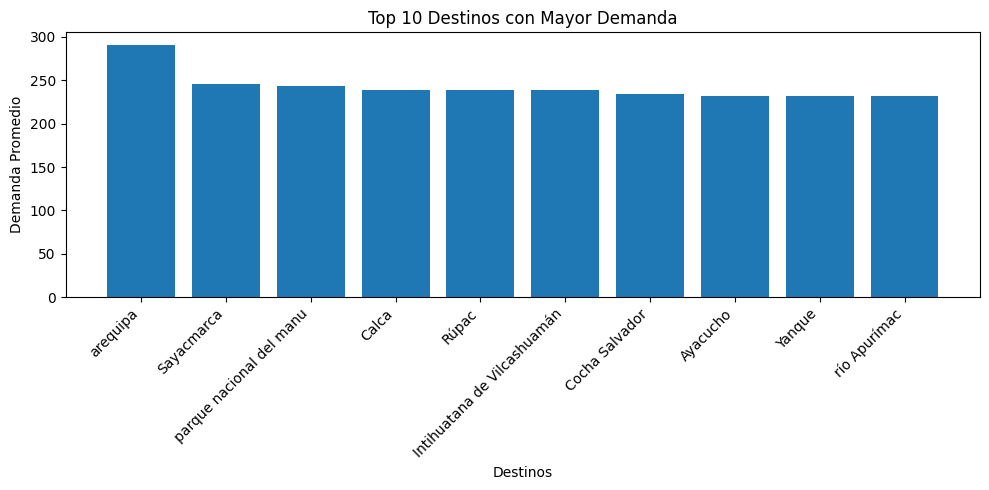

In [37]:
import matplotlib.pyplot as plt

df_top10 = df_pd_demanda.sort_values("demanda_promedio", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(df_top10["destino"], df_top10["demanda_promedio"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Destinos")
plt.ylabel("Demanda Promedio")
plt.title("Top 10 Destinos con Mayor Demanda")
plt.tight_layout()
plt.show()

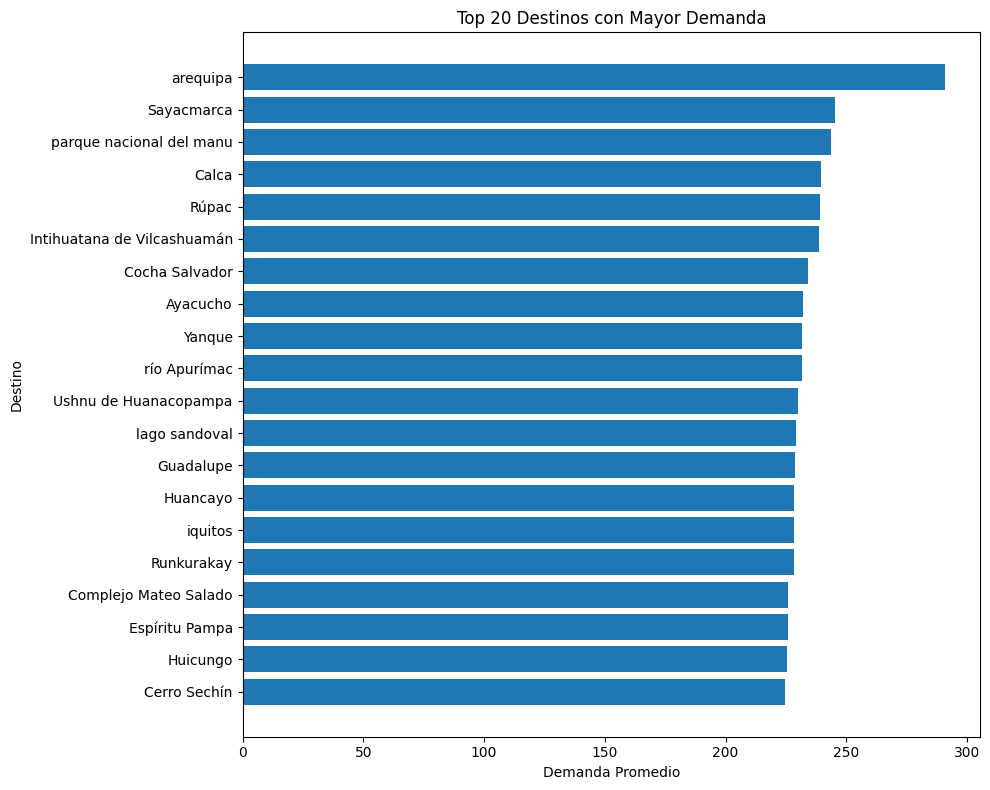

In [42]:
import matplotlib.pyplot as plt

df_top20 = (df_pd_demanda.sort_values("demanda_promedio", ascending=False).head(20)).iloc[::-1]

plt.figure(figsize=(10, 8))
plt.barh(df_top20["destino"], df_top20["demanda_promedio"])
plt.xlabel("Demanda Promedio")
plt.ylabel("Destino")
plt.title("Top 20 Destinos con Mayor Demanda")
plt.tight_layout()
plt.show()

### ¿Qué destino tiene mejores reseñas?

In [44]:
from pyspark.sql import functions as F

df_sentimiento = (
    df_unificado_sm.groupBy("destino")
    .agg(
        F.avg("nivel_aceptacion").alias("sentimiento_promedio")
    )
    .orderBy(F.desc("sentimiento_promedio"))
)

In [46]:
df_sentimiento.show()

+--------------------+--------------------+
|             destino|sentimiento_promedio|
+--------------------+--------------------+
|             juliaca|  0.8422539631525675|
|             lagunas|  0.7616784423589706|
|Complejo Mateo Sa...| 0.49713875934845064|
|        Huchuy Qosqo| 0.46940326187517734|
|Intihuatana de Vi...| 0.44747392954053106|
|             Garagay| 0.44345094131518015|
|         Puca Pucara|  0.4368960618972778|
|          Estaquería|  0.4354452910557599|
|       Tambo de Mora|  0.4334483742713928|
|            Arwaturo|  0.4070433820738937|
|             Máncora| 0.40601768761080026|
| Fortaleza de Acaray| 0.40019742348422743|
|              Pukara|  0.3943582088200014|
| Incahuasi de Cañete|  0.3911772683262825|
|        Sacsayhuamán|  0.3896211725779069|
|Pampa de las Llam...|  0.3861252188682556|
|              Tumbes|  0.3855058074182605|
|          Honcopampa|  0.3827055139201028|
|              Vitcos| 0.37502487094113324|
|         Tambomachay| 0.3706921

In [48]:
destino_mejor_reseña = df_sentimiento.first()["destino"]
print("Destino con mejor reseñas:", destino_mejor_reseña)

Destino con mejor reseñas: juliaca


In [50]:
df_sent_pd = df_sentimiento.toPandas()

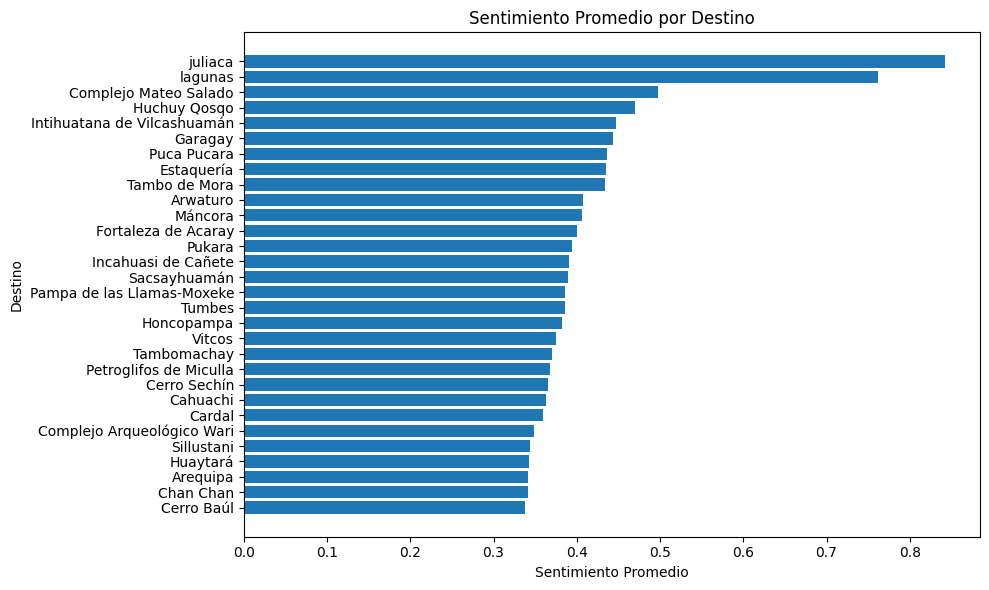

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh((df_sent_pd["destino"].head(30)).iloc[::-1], (df_sent_pd["sentimiento_promedio"].head(30)).iloc[::-1])
plt.xlabel("Sentimiento Promedio")
plt.ylabel("Destino")
plt.title("Sentimiento Promedio por Destino")
plt.tight_layout()
plt.show()

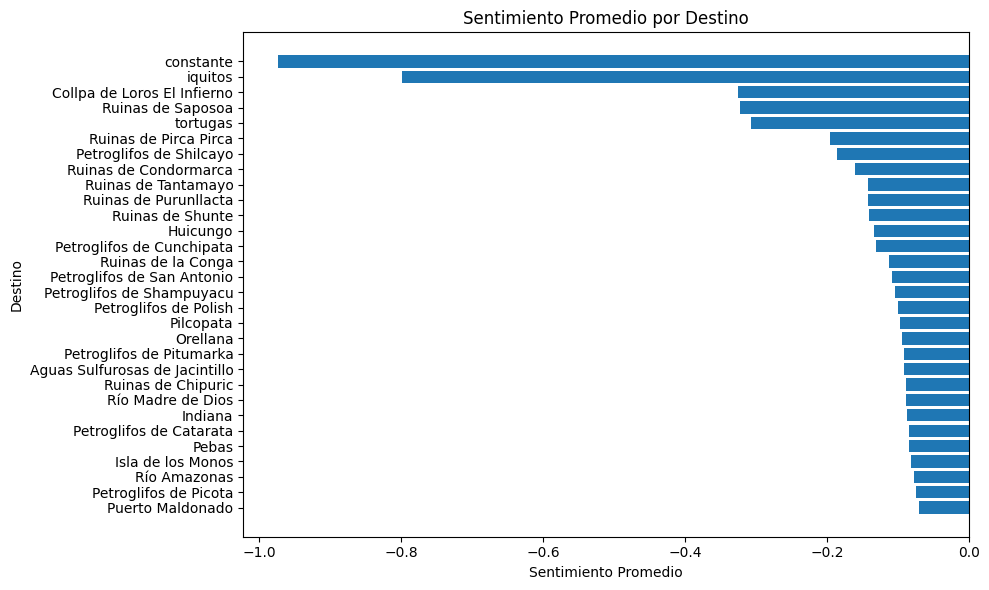

In [58]:
plt.figure(figsize=(10, 6))
plt.barh(df_sent_pd["destino"].tail(30), df_sent_pd["sentimiento_promedio"].tail(30))
plt.xlabel("Sentimiento Promedio")
plt.ylabel("Destino")
plt.title("Sentimiento Promedio por Destino")
plt.tight_layout()
plt.show()

### ¿En qué mes del año se tiene mayor demanda?

In [61]:
from pyspark.sql import functions as F

df_mes = df_unificado_sm.withColumn(
    "mes", F.month("fecha")
)

In [62]:
df_estacionalidad = (
    df_mes.groupBy("mes")
    .agg(F.avg("demanda_score").alias("demanda_promedio"))
    .orderBy("mes")
)

In [63]:
df_estacionalidad.show()

+---+------------------+
|mes|  demanda_promedio|
+---+------------------+
|  1|167.16427587118662|
|  2|169.57723364042135|
|  3|168.72277128156497|
|  4|164.53070467926446|
|  5|168.18749001037125|
|  6|167.14824040851514|
|  7| 171.6256694421392|
|  8|170.53833156482906|
|  9|164.14425445714687|
| 10|170.54732830819617|
| 11|168.43882794960234|
| 12|  166.984022759941|
+---+------------------+



In [64]:
df_est_pd = df_estacionalidad.toPandas()

In [68]:
meses = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

df_est_pd["mes_nombre"] = df_est_pd["mes"].map(meses)

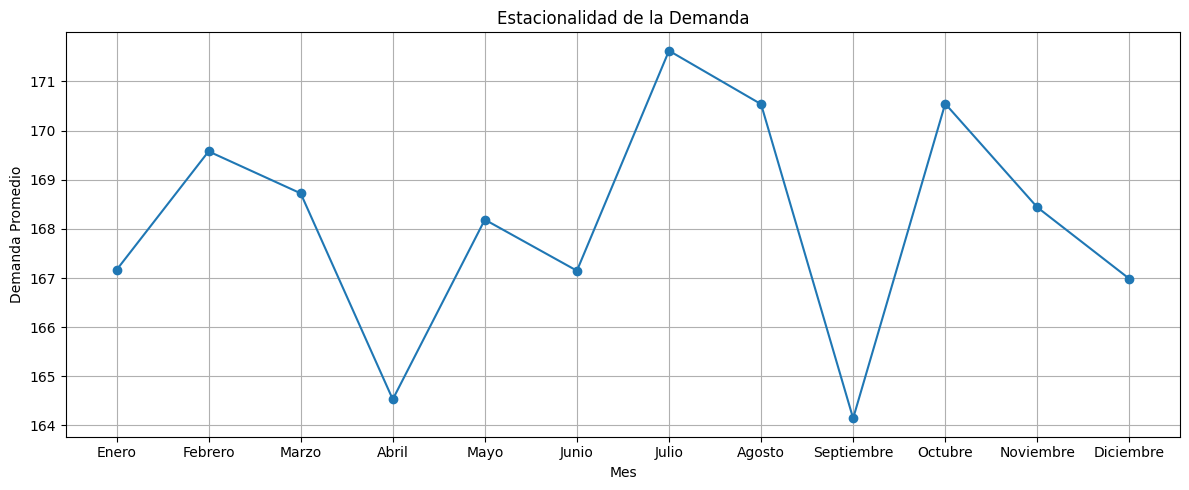

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_est_pd["mes_nombre"], df_est_pd["demanda_promedio"], marker="o")
plt.xlabel("Mes")
plt.ylabel("Demanda Promedio")
plt.title("Estacionalidad de la Demanda")
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
mes_top = df_est_pd.loc[df_est_pd["demanda_promedio"].idxmax()]
print("Mes con mayor demanda:", mes_top["mes_nombre"])
print("Demanda promedio:", mes_top["demanda_promedio"])

Mes con mayor demanda: Julio
Demanda promedio: 171.6256694421392


In [73]:
def estacion_peru(mes):
    if mes in [12, 1, 2]:
        return "Verano"
    elif mes in [3, 4, 5]:
        return "Otoño"
    elif mes in [6, 7, 8]:
        return "Invierno"
    elif mes in [9, 10, 11]:
        return "Primavera"

print("Época del año con más viajes:", estacion_peru(int(mes_top["mes"])))

Época del año con más viajes: Invierno


### Clasificar comentarios positivos, negativos y neutros

In [74]:
from pyspark.sql import functions as F

df_sentimientos = df_unificado_sm.withColumn(
    "sentimiento",
    F.when(F.col("nivel_aceptacion") > 0.2, "Positivo")
     .when((F.col("nivel_aceptacion") >= -0.2) & (F.col("nivel_aceptacion") <= 0.2), "Neutro")
     .otherwise("Negativo")
)

In [79]:
orden = ["Positivo", "Neutro", "Negativo"]

df_sentimiento_count = df_sentimiento_count.withColumn(
    "orden",
    F.when(F.col("sentimiento") == "Positivo", 1)
     .when(F.col("sentimiento") == "Neutro", 2)
     .when(F.col("sentimiento") == "Negativo", 3)
     .otherwise(99)  
)

df_sentimiento_count = df_sentimiento_count.orderBy("orden").drop("orden")

In [82]:
pdf_sentimiento = df_sentimiento_count.toPandas()

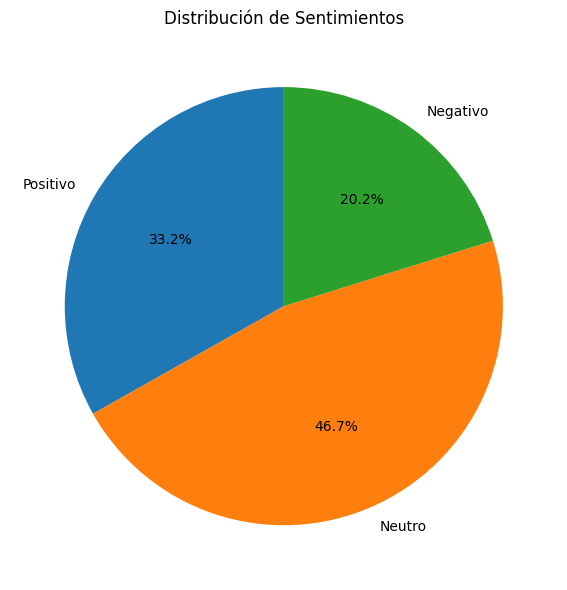

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.pie(
    pdf_sentimiento["count"],
    labels=pdf_sentimiento["sentimiento"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Distribución de Sentimientos")
plt.tight_layout()
plt.show()

### Promedio de sentimiento por departamento

In [84]:
import pyspark.sql.functions as F

df_sent_depto = df_unificado_sm.groupBy("departamento").agg(
    F.avg("nivel_aceptacion").alias("sent_promedio")
).orderBy(F.desc("sent_promedio"))

In [100]:
df_sent_depto=df_sent_depto.dropna()

In [106]:
df_sent_depto.show(24)

+-------------+--------------------+
| departamento|       sent_promedio|
+-------------+--------------------+
|        Tacna| 0.36829461702486366|
|          Ica| 0.36148623052765344|
|     Ayacucho| 0.27711652885295956|
| Huancavelica| 0.27351930290460585|
|     Moquegua|   0.269032483262227|
|         Puno| 0.26372984837587565|
|       Tumbes| 0.26323343740580196|
|         Lima| 0.24818005139665514|
|       Áncash|  0.2050539481144179|
|  La Libertad| 0.20040116634217794|
|        Piura| 0.19926753680028197|
|        Cusco| 0.19354410106264372|
|     Arequipa| 0.19010306355683393|
|    Cajamarca| 0.17649329713131773|
|   Lambayeque| 0.15527085632537352|
|     Amazonas| 0.13750487396609043|
|        Junín|  0.0819683887216669|
|     Apurímac| 0.03607039028904827|
|      Huánuco|0.007810941470542595|
|        Pasco|0.004650174342888467|
|       Loreto|0.004630697919935932|
|      Ucayali|7.810662485962751E-4|
|   San Martín|-0.01729840234826707|
|Madre de Dios|-0.05328895702141072|
+

In [104]:
pdf_sent_depto = df_sent_depto.toPandas()

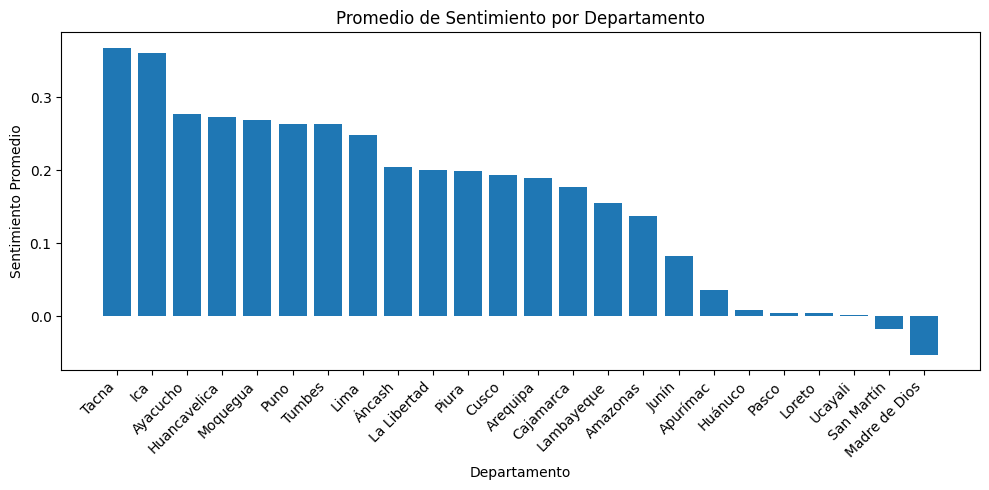

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(pdf_sent_depto["departamento"], pdf_sent_depto["sent_promedio"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Departamento")
plt.ylabel("Sentimiento Promedio")
plt.title("Promedio de Sentimiento por Departamento")
plt.tight_layout()
plt.show()

### Filtrar comentarios más tóxicos o más positivos

In [107]:
df_toxicos = df_unificado_sm.orderBy(F.asc("nivel_aceptacion")).limit(10)

df_toxicos_pd = df_toxicos.select(
    "id", "destino", "comentario", "nivel_aceptacion"
).toPandas()

In [108]:
df_positivos = df_unificado_sm.orderBy(F.desc("nivel_aceptacion")).limit(10)

df_positivos_pd = df_positivos.select(
    "id", "destino", "comentario", "nivel_aceptacion"
).toPandas()

In [110]:
print("Comentarios más tóxicos:")
df_toxicos_pd

Comentarios más tóxicos:


,id,destino,comentario,nivel_aceptacion
0,f16fcaa6-3432-4a43-994f-2ec73cf36802,Pozuzo,Que no me gusto el lodge en Pozuzo. Lleno de v...,-0.988253
1,903f18d4-f24d-41fe-9abc-e8670016c21a,Villa Rica,Que triste la comida en Villa Rica. Mejor Jena...,-0.987603
2,46b23e68-8898-4e41-a84c-ed37e7c5e3a7,Jenaro Herrera,Que mal hecho el lodge en Jenaro Herrera. Llen...,-0.987506
3,3a202323-d765-4d68-b627-b1668e976131,Petroglifos de Santa Rosa,Que deprimente el lodge en Petroglifos de Sant...,-0.987416
4,1f59d13b-594a-4332-b52d-066d72864edd,Pebas,Que no me gusto el lodge en Pebas. Lleno de bo...,-0.987001
5,5781f88c-6bfc-4583-a4ad-5c0b1daa6596,Jenaro Herrera,Que malogrado el lodge en Jenaro Herrera. Llen...,-0.986504
6,a41c9273-9d46-4658-9527-af97d832bf01,Petroglifos de Balsapuerto,Que triste el lodge en Petroglifos de Balsapue...,-0.986476
7,7af508a2-356f-46a0-a65a-05f68c1c846d,Mazán,Que bulloso el lodge en Mazán. Lleno de falta ...,-0.986411
8,bdd00476-b16e-4a50-a205-a0f03b3906b6,Petroglifos de Santa Cruz,Que mal aspecto el lodge en Petroglifos de San...,-0.986363
9,6be10b9e-33cc-46bb-94e8-0efb26778d05,San José,Que debil el lodge en San José de Sisa. Lleno ...,-0.986277


In [111]:
print("Comentarios más positivos:")
df_positivos_pd

Comentarios más positivos:


,id,destino,comentario,nivel_aceptacion
0,5c57c840-5261-4498-ba8e-1e2694146a24,Catarata de Bayoz,Mi me encanta el misterio de Catarata de Bayoz...,0.981275
1,ae9ad2b2-a062-402f-a1e3-9ee754dd03cd,Tortugas,Me lo habían recomendado mucho. Tortugas tiene...,0.981226
2,9380f065-4bb3-4441-9ac1-c6c1456627e2,Tumbes,Fue un viaje familiar. Tumbes tiene un encanto...,0.980744
3,367ef1c2-b060-458d-8a22-898ec5f206b7,Macro,He ido 10 veces. Macro tiene un encanto especi...,0.980679
4,f444715b-3a20-422b-8f5f-3974606b18f3,Chota,Mi pata vive ahí. Chota tiene un encanto espec...,0.979668
5,e5921a45-0938-4c16-b124-aceeb2cb16e5,San Ignacio,He ido 10 veces. San Ignacio tiene un encanto ...,0.979663
6,33420823-ffa1-4948-bfa9-ebcbdf42a97c,Playa Hermosa,Conozco como la palma de mi mano. Playa Hermos...,0.978889
7,edf9f892-7c28-46a8-90b8-ea096d894ddc,Tortugas,Me enamoré del lugar. Tortugas tiene un encant...,0.978883
8,c24512b0-11ec-4da6-81dc-244cbae84576,Fortaleza de Huaylillas,Mi que buena musica tienen de Fortaleza de Hua...,0.978796
9,acf3f396-3203-4492-9984-8519284481ff,San José,Fui con mis amigos de la universidad. San José...,0.978791


### Cantidad de destinos

In [112]:
num_destinos_unicos = df_unificado_sm.select("destino").distinct().count()
print("Cantidad de destinos únicos:", num_destinos_unicos)

Cantidad de destinos únicos: 421


In [114]:
df_conteo_destinos = df_unificado_sm.groupBy("destino").count().orderBy(F.desc("count"))
df_conteo_destinos.show(truncate=False)

+-------------------------+-----+
|destino                  |count|
+-------------------------+-----+
|Tumbes                   |322  |
|San José                 |319  |
|Kuélap                   |310  |
|Cusco                    |293  |
|Máncora                  |263  |
|Trujillo                 |262  |
|Iquitos                  |235  |
|Chan Chan                |218  |
|Santa Rosa               |218  |
|Chachapoyas              |189  |
|Arequipa                 |187  |
|Santiago de Chuco        |184  |
|Huamachuco               |182  |
|Paita                    |182  |
|Petroglifos de Quiaca    |181  |
|Cumbemayo                |181  |
|Baños del Inca           |178  |
|Petroglifos de Manga     |172  |
|Petroglifos de Santa Rosa|172  |
|Chota                    |172  |
+-------------------------+-----+
only showing top 20 rows



In [115]:
pdf_conteo_destinos = df_conteo_destinos.toPandas()

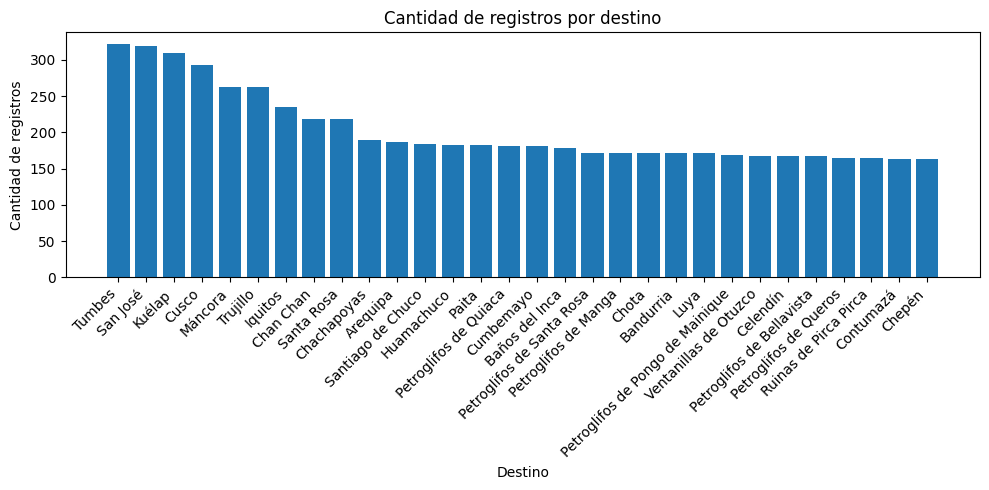

In [117]:
plt.figure(figsize=(10,5))
plt.bar(pdf_conteo_destinos["destino"].head(30), pdf_conteo_destinos["count"].head(30))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Destino")
plt.ylabel("Cantidad de registros")
plt.title("Cantidad de registros por destino")
plt.tight_layout()
plt.show()

### ¿Qué destino con menos demanda?

In [119]:
destino_menor_demanda = df_demanda.orderBy(F.asc("demanda_promedio")).first()
print("Destino con menor demanda:", destino_menor_demanda["destino"])
print("Demanda promedio:", destino_menor_demanda["demanda_promedio"])

Destino con menor demanda: Tumbes
Demanda promedio: 45.767789038525244


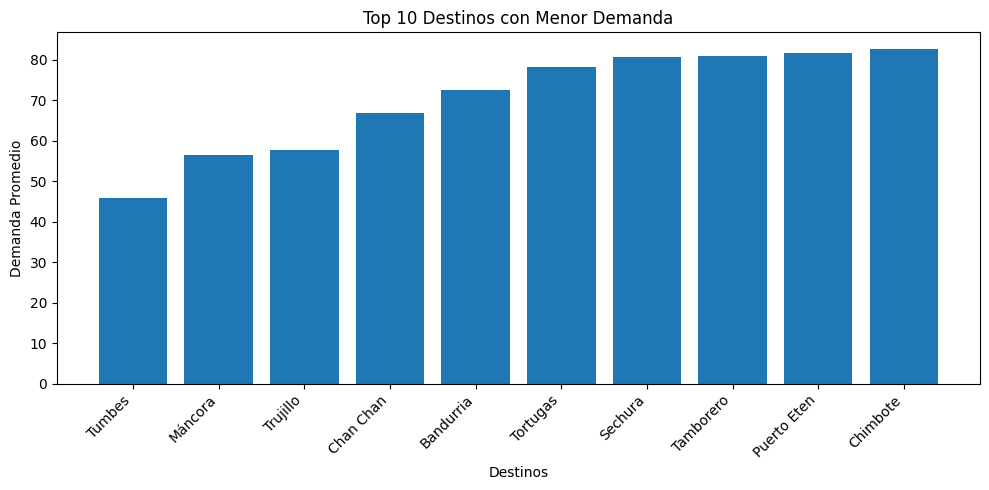

In [134]:
import matplotlib.pyplot as plt

df_last10 = df_pd_demanda.sort_values("demanda_promedio", ascending=False).tail(10)

plt.figure(figsize=(10, 5))
plt.bar(df_last10["destino"].iloc[::-1], df_last10["demanda_promedio"].iloc[::-1])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Destinos")
plt.ylabel("Demanda Promedio")
plt.title("Top 10 Destinos con Menor Demanda")
plt.tight_layout()
plt.show()

### ¿En que epoca del año hay mas viajes?

In [118]:
def estacion_peru(mes):
    if mes in [12, 1, 2]:
        return "Verano"
    elif mes in [3, 4, 5]:
        return "Otoño"
    elif mes in [6, 7, 8]:
        return "Invierno"
    elif mes in [9, 10, 11]:
        return "Primavera"

Época del año con más viajes: Invierno


In [129]:
df_est_pd["estacion"] = df_est_pd["mes"].apply(estacion_peru)

In [130]:
df_estacion = (
    df_est_pd.groupby("estacion")["demanda_promedio"]
    .mean()
    .reset_index()
)

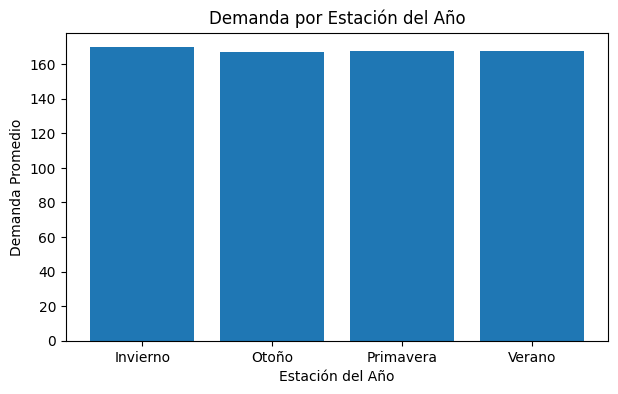

In [131]:
plt.figure(figsize=(7,4))
plt.bar(df_estacion["estacion"], df_estacion["demanda_promedio"])
plt.xlabel("Estación del Año")
plt.ylabel("Demanda Promedio")
plt.title("Demanda por Estación del Año")
plt.show()

In [132]:
print("Época del año con más viajes:", estacion_peru(int(mes_top["mes"])))

Época del año con más viajes: Invierno


### ¿Que destino tiene peores reseñas?

In [127]:
df_sentimiento = df_unificado_sm.groupBy("destino").agg(
    F.avg("nivel_aceptacion").alias("sentimiento_promedio")
)

In [128]:
df_sentimiento.orderBy(F.asc("sentimiento_promedio")).show(truncate=False)

+---------------------------+--------------------+
|destino                    |sentimiento_promedio|
+---------------------------+--------------------+
|constante                  |-0.9743010401725769 |
|iquitos                    |-0.7986546523041196 |
|Collpa de Loros El Infierno|-0.3253335853417714 |
|Ruinas de Saposoa          |-0.3229441093663647 |
|tortugas                   |-0.3078483598572867 |
|Ruinas de Pirca Pirca      |-0.19586307099371245|
|Petroglifos de Shilcayo    |-0.1855687661604448 |
|Ruinas de Condormarca      |-0.1607547139971511 |
|Ruinas de Tantamayo        |-0.1429020102946989 |
|Ruinas de Purunllacta      |-0.14190786141975253|
|Ruinas de Shunte           |-0.14072179002361698|
|Huicungo                   |-0.13357845517515227|
|Petroglifos de Cunchipata  |-0.13154921909562903|
|Ruinas de la Conga         |-0.11279478906853799|
|Petroglifos de San Antonio |-0.10898353735605876|
|Petroglifos de Shampuyacu  |-0.10375433994664086|
|Petroglifos de Polish      |-0

In [121]:
destino_peores_resenas = df_sentimiento.orderBy(F.asc("sentimiento_promedio")).first()
print("Destino con peores reseñas:", destino_peores_resenas["destino"])
print("Sentimiento promedio:", destino_peores_resenas["sentimiento_promedio"])

Destino con peores reseñas: constante
Sentimiento promedio: -0.9743010401725769


Constante-Piura es un pueblo de pescadores y caleta en el distrito de Sechura. Se caracteriza por su actividad pesquera, especialmente la captura de guitarra, raya, langostinos y otros pescados, y es conocida por su gastronomía local, que incluye el chinguirito (ceviche de guitarra) y la tortilla de raya.

## 4. Selección y aplicación del modelo machine learning (Modelo de para la predicción de demanda)

In [10]:
df_posts_unificado=spark.read.parquet("parquets/df_posts_unificado.parquet")
df_comments_unificado_sm= spark.read.parquet("parquets/df_comments_unificado_sm.parquet")

In [11]:
df_unificado_sm = df_posts_unificado.unionByName(df_comments_unificado_sm)
df_unificado_sm.printSchema()
df_unificado_sm.count()

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)



46148

### 4.1 Preparar dataset para entrenamiento

In [26]:
from pyspark.sql import functions as F

In [136]:
df_unificado_sm.printSchema()

root
 |-- id: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- comentario: string (nullable = true)
 |-- fecha: timestamp (nullable = true)
 |-- reacciones: integer (nullable = true)
 |-- destino: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- nivel_aceptacion: float (nullable = true)
 |-- demanda: string (nullable = true)
 |-- demanda_score: double (nullable = true)



In [27]:
# Crear columna mes
df_modelo = df_unificado_sm.withColumn("mes", F.month("fecha"))

In [28]:
# Función de estación Perú
def estacion_peru(mes):
    if mes in [12, 1, 2]:
        return "Verano"
    elif mes in [3, 4, 5]:
        return "Otoño"
    elif mes in [6, 7, 8]:
        return "Invierno"
    else:
        return "Primavera"

In [29]:
# Registrar UDF
from pyspark.sql.types import StringType
estacion_udf = F.udf(estacion_peru, StringType())

In [30]:
df_modelo = df_modelo.withColumn("estacion", estacion_udf(F.col("mes")))

In [31]:
# Seleccionar solo las columnas útiles
df_modelo = df_modelo.select(
    "destino",
    "departamento",
    "mes",
    "estacion",
    "demanda"
)

In [32]:
df_modelo=df_modelo.dropna()

In [146]:
df_modelo.show(5)

+--------------------+-------------+---+---------+-------+
|             destino| departamento|mes| estacion|demanda|
+--------------------+-------------+---+---------+-------+
|        San Hilarión|   San Martín|  6| Invierno|  Media|
|             Bretaña|       Loreto|  9|Primavera|  Media|
|             Pachiza|   San Martín| 12|   Verano|   Alta|
|Parque Nacional Y...|        Pasco|  4|    Otoño|   Alta|
|Collpa de Loros E...|Madre de Dios| 12|   Verano|   Baja|
+--------------------+-------------+---+---------+-------+
only showing top 5 rows



In [33]:
df_modelo.count()

45948

### 4.2 Creación del pipeline con sparkMl

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [35]:
index_destino = StringIndexer(inputCol="destino", outputCol="destino_index")
index_departamento = StringIndexer(inputCol="departamento", outputCol="departamento_index")
index_estacion = StringIndexer(inputCol="estacion", outputCol="estacion_index")

# Label (demanda)
index_demanda = StringIndexer(inputCol="demanda", outputCol="label")

In [36]:
encoder = OneHotEncoder(
    inputCols=["destino_index", "departamento_index", "estacion_index"],
    outputCols=["destino_vec", "departamento_vec", "estacion_vec"]
)

In [37]:
assembler = VectorAssembler(
    inputCols=["destino_vec", "departamento_vec", "estacion_vec", "mes"],
    outputCol="features"
)

**Seleccionamos random Forest**

In [38]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100
)

In [39]:
pipeline = Pipeline(stages=[
    index_destino,
    index_departamento,
    index_estacion,
    index_demanda,
    encoder,
    assembler,
    rf
])

In [40]:
train_data, test_data = df_modelo.randomSplit([0.8, 0.2], seed=42)

In [41]:
model = pipeline.fit(train_data)

## 5. Evaluación del modelo

In [42]:
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.3919308357348703


### 5.1 Probando un modelo de XGBOOST

In [2]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 2.0 MB/s  0:00:04 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn]━━━━━ 2/3 [scikit-learn]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [66]:
df = df_unificado_sm.toPandas()

In [67]:
df=df.dropna()

In [77]:
df["mes"] = df["fecha"].dt.month

# Crear estación según Perú
def estacion_peru(mes):
    if mes in [12, 1, 2]:
        return "Verano"
    elif mes in [3, 4, 5]:
        return "Otoño"
    elif mes in [6, 7, 8]:
        return "Invierno"
    elif mes in [9, 10, 11]:
        return "Primavera"

df["estacion"] = df["mes"].apply(estacion_peru)


In [78]:
map_demanda = {
    "Baja": 0,
    "Media": 1,
    "Alta": 2
}

df["demanda_label"] = df["demanda"].map(map_demanda)

In [87]:
features = [
    "destino", "departamento", "estacion",  # categóricas
    "mes" # numéricas
]

target = "demanda_label"

X = df[features]
y = df[target]

In [88]:
numeric_features = ["mes"]
categorical_features = ["destino", "departamento", "estacion"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [89]:
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss"
)

In [90]:
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [92]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [93]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.40119695321001086
              precision    recall  f1-score   support

           0       0.41      0.70      0.52      3650
           1       0.39      0.32      0.35      2999
           2       0.32      0.07      0.11      2541

    accuracy                           0.40      9190
   macro avg       0.37      0.36      0.33      9190
weighted avg       0.38      0.40      0.35      9190



## 6 Exportando modelo

In [94]:
model

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [96]:
import joblib

# Guarda pipeline (preprocesador + XGBoost)
joblib.dump(pipeline, "modelo_demanda_pipeline.pkl")

# Guarda el mapeo (label -> int) y el inverso (int -> label)
map_demanda = {"Baja": 0, "Media": 1, "Alta": 2}
inv_map_demanda = {v: k for k, v in map_demanda.items()}

joblib.dump(map_demanda, "map_demanda.pkl")
joblib.dump(inv_map_demanda, "inv_map_demanda.pkl")

print("Modelos y mapeos guardados.")

Modelos y mapeos guardados.


### probando importación del modelo

In [97]:
import joblib
import pandas as pd
from datetime import datetime

# Cargar
model = joblib.load("modelo_demanda_pipeline.pkl")
inv_map = joblib.load("inv_map_demanda.pkl")  # para decodificar la predicción

# Funciones auxiliares para crear mes y estación desde fecha (string o datetime)
def estacion_peru(mes):
    if mes in [12, 1, 2]:
        return "Verano"
    elif mes in [3, 4, 5]:
        return "Otoño"
    elif mes in [6, 7, 8]:
        return "Invierno"
    else:
        return "Primavera"

def preparar_input(destino, departamento, fecha_str):
    # fecha_str puede ser "2025-08-15" o datetime
    fecha = pd.to_datetime(fecha_str)
    mes = fecha.month
    estacion = estacion_peru(mes)
    # construir DataFrame con las mismas columnas usadas en X (orden no importa si usas pandas)
    df_in = pd.DataFrame([{
        "destino": destino,
        "departamento": departamento,
        "estacion": estacion,
        "mes": mes
    }])
    return df_in

# Ejemplo
entrada = preparar_input("Huanchaco", "La Libertad", "2025-08-15")
pred_num = model.predict(entrada)[0]          # devuelve 0/1/2
pred_label = inv_map[int(pred_num)]           # volver a "Baja"/"Media"/"Alta"

print("Predicción numérica:", pred_num)
print("Predicción etiqueta:", pred_label)

Predicción numérica: 1
Predicción etiqueta: Media
